In [1]:
import pymongo
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import folium
from folium.plugins import HeatMap

# CARGA DE DATOS

In [2]:
# Cargamos el archivo JSON desde la URL
url = 'https://opendata-ajuntament.barcelona.cat/resources/bcn/EstadisticaPadro/imm/2022/2022_pad_imm_mdbas_sexe_edat-q_nacionalitat-g.json'

# Realizamos una solicitud GET para obtener el contenido del archivo JSON
response = requests.get(url)

# Verificamos el estado de la solicitud antes de intentar procesar los datos
if response.status_code == 200:
    # Cargamos el contenido del archivo JSON en una variable Python
    data = response.json()
    print("El archivo JSON se ha cargado correctamente desde la URL.")
else:
    print("Error al descargar el archivo JSON.")

def main():
    if data:
        # Utilizamos pymongo para establecer la conexión con el servidor de MongoDB en localhost
        try:
            client = pymongo.MongoClient('mongodb://localhost:27017/')
            db = client['barcelona_immigrants']   # Creamos una base de datos
            collection = db['immigration_data']   # Creamos una colección para almacenar los datos del archivo JSON
            print("Conexión establecida con MongoDB.")
            collection.insert_many(data)  # Insertamos los datos en la colección
            print("Datos insertados correctamente en MongoDB.")
        except pymongo.errors.ConnectionFailure as e:
            print(f'Error al conectar con MongoDB: {e}')
    else:
        print("No se pudieron cargar los datos.")
        
main()

El archivo JSON se ha cargado correctamente desde la URL.
Conexión establecida con MongoDB.
Datos insertados correctamente en MongoDB.


# MÉTODO CRUD

## Creación

In [3]:
try:
    client = pymongo.MongoClient('mongodb://localhost:27017/')
    db = client['barcelona_immigrants']   # Base de datos
    collection = db['immigration_data']   # Colección para los datos de inmigración
    print("Conexión establecida con MongoDB.")
except pymongo.errors.ConnectionFailure as e:
    print(f'Error al conectar con MongoDB: {e}')

def insert_data(data, collection):
    if data:
        try:
            # Insertamos los datos en la colección
            collection.insert_many(data)  # Para insertar múltiples documentos en la colección de una sola vez
            print("Datos insertados correctamente.")
        except pymongo.errors.PyMongoError as e:
            print(f'Error al insertar datos en MongoDB: {e}')
            
# Creamos un nuevo documento
new_document = [
    {
        "Any": 2022,
        "Codi_Districte": 1,
        "Nom_Districte": "Ciutat Vella",
        "Codi_Barri": 1,
        "Nom_Barri": "el Raval",
        "AEB": 1,
        "Seccio_Censal": 1001,
        "Valor": 10,
        "NACIONALITAT_G": 1,
        "EDAT_Q": 0,   # Por ejemplo, edad entre 0-4 años 
        "SEXE": 1
    },
    {
        "Any": 2022, 
        "Codi_Districte": 3,  
        "Nom_Districte": "Sants-Montjuïc",
        "Codi_Barri": 18,
        "Nom_Barri": "Sants",
        "AEB": 72,
        "Seccio_Censal": 3094,
        "Valor": 10,  
        "NACIONALITAT_G": 3,
        "EDAT_Q": 2,  # Edad entre 5-9 años 
        "SEXE": 2  
    }
]

# Llamamos a la función para insertar los nuevos documentos en la colección
insert_data(new_document, collection)

Conexión establecida con MongoDB.
Datos insertados correctamente.


## Lectura

In [4]:
def get_immigrant_data(collection, filter={}):
    try:
        # Obtenemos datos según el filtro indicado y convertirmos el cursor de resultados a una lista de Python
        result = collection.find(filter)
        return list(result)
    except pymongo.errors.PyMongoError as e:
        print(f'Error al obtener datos desde MongoDB: {e}')
        return []
        
# Datos de inmigrantes del barrio "Sants"
immigrant_data_barrio = get_immigrant_data(collection, {"Nom_Barri": "Sants"})
df = pd.DataFrame(immigrant_data_barrio)
df

,_id,Any,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,AEB,Seccio_Censal,Valor,NACIONALITAT_G,EDAT_Q,SEXE
0,6640dae4e434861efbc0d1d1,2022,3,Sants-Montjuïc,18,Sants,72,3086,..,1,0,2
1,6640dae4e434861efbc0d1d2,2022,3,Sants-Montjuïc,18,Sants,72,3086,..,1,1,2
2,6640dae4e434861efbc0d1d3,2022,3,Sants-Montjuïc,18,Sants,72,3086,..,1,2,2
3,6640dae4e434861efbc0d1d4,2022,3,Sants-Montjuïc,18,Sants,72,3086,..,1,4,1
4,6640dae4e434861efbc0d1d5,2022,3,Sants-Montjuïc,18,Sants,72,3086,..,1,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...
2634,6640f106e0afe35ea51a3f96,2022,3,Sants-Montjuïc,18,Sants,76,3114,..,3,11,2
2635,6640f106e0afe35ea51a3f97,2022,3,Sants-Montjuïc,18,Sants,76,3114,..,3,13,1
2636,6640f106e0afe35ea51a3f98,2022,3,Sants-Montjuïc,18,Sants,76,3114,..,3,16,1
2637,6640f106e0afe35ea51a3f99,2022,3,Sants-Montjuïc,18,Sants,76,3114,..,3,17,2


## Actualización

In [5]:
def update_immigrant_data(collection, filter, update):
    try:
        # Definimos un filtro para encontrar el documento que queremos actualizar
        collection.update_many(filter, {"$set": update})
        print("Datos actualizados correctamente.")
    except pymongo.errors.PyMongoError as e:
        print(f'Error al actualizar datos en MongoDB: {e}')
        
# Actualizamos el documento encontrado con las modificaciones definidas
update_filter = {"Nom_Barri": "Sants"}
update_data = {"Valor": 15}  # Actualiza el valor a 15
update_immigrant_data(collection, update_filter, update_data)

Datos actualizados correctamente.


## Eliminación

In [6]:
def delete_immigrant_data(collection, filter):
    try:
       # Definimos un filtro para encontrar el documento que queremos eliminar
        collection.delete_many(filter)
        print("Datos eliminados correctamente.")
    except pymongo.errors.PyMongoError as e:
        print(f'Error al eliminar datos en MongoDB: {e}')

# Eliminamos el documento encontrado que cumple con el filtro
delete_filter = {"Nom_Barri": "Sants"}
delete_immigrant_data(collection, delete_filter)

Datos eliminados correctamente.


# ANÁLISIS

In [7]:
# URL del archivo JSON original
url = 'https://opendata-ajuntament.barcelona.cat/resources/bcn/EstadisticaPadro/imm/2022/2022_pad_imm_mdbas_sexe_edat-q_nacionalitat-g.json'

# Solicitud GET para obtener el contenido del archivo JSON
response = requests.get(url)

# Verificamos el estado de la solicitud y cargamos el contenido del archivo en una variable Python
if response.status_code == 200:
    original_data = response.json()
    print("El archivo JSON original se ha cargado correctamente desde la URL.")
else:
    print("Error al descargar el archivo JSON.")

# Establecemos la conexión con el servidor de MongoDB
client = pymongo.MongoClient('mongodb://localhost:27017/')

# Accedemos a la base de datos 'barcelona_immigrants'
db = client['barcelona_immigrants']

# Accedemos a la colección 'immigration_data'
collection = db['immigration_data']

# Eliminamos todos los documentos existentes en la colección
collection.delete_many({})

# Insertamos los datos originales en la colección
collection.insert_many(original_data)

print("\nSe han restaurado los datos originales en la base de datos MongoDB.")

El archivo JSON original se ha cargado correctamente desde la URL.

Se han restaurado los datos originales en la base de datos MongoDB.


## Inmigrantes según nacionalidad y sexo

In [8]:
# Pipeline de agregación para contar inmigrantes por nacionalidad y sexo
pipeline = [
    {"$group": {"_id": {"NACIONALITAT_G": "$NACIONALITAT_G", "SEXE": "$SEXE"},"Total": {"$sum": 1}}},
    { "$project": {"_id": 0, "NACIONALITAT_G": "$_id.NACIONALITAT_G", "SEXE": "$_id.SEXE", "Total": 1}}
]

# Realizamos una consulta para obtener los datos procesados mediante el pipeline de agregación
cursor = collection.find()

# Creamos un DataFrame a partir de los documentos obtenidos de la consulta
df = pd.DataFrame(list(cursor))

# Convertimos las columnas de interés a tipos numéricos
df['NACIONALITAT_G'] = df['NACIONALITAT_G'].astype(int)
df['SEXE'] = df['SEXE'].astype(int)

# Agrupamos por nacionalidad y sexo, contando el número de inmigrantes en cada grupo
grouped_data = df.groupby(['NACIONALITAT_G', 'SEXE']).size().reset_index(name='Total')

# Mapeamos los códigos de nacionalidad para agruparlos más fácilmente
nacionalidad_map = {
    1: 'Española',
    2: 'Extranjera UE',
    3: 'Extranjera no UE',
    None: 'Desconocida'
}

# Reemplazamos los códigos de nacionalidad con nombres descriptivos mediante 'map'
grouped_data['Nacionalidad'] = grouped_data['NACIONALITAT_G'].map(nacionalidad_map)  
grouped_data['Sexo'] = grouped_data['SEXE']

# Mostramos los datos agrupados antes de graficar
print("Datos agrupados por nacionalidad y sexo:\n")
print(f"{'Nacionalidad':<20} {'Sexo':<10} {'Total':<5}")
print("-" * 40)
for index, row in grouped_data.iterrows():
    print(f"{row['Nacionalidad']:<20} {row['Sexo']:<10} {row['Total']:<5}")

Datos agrupados por nacionalidad y sexo:

Nacionalidad         Sexo       Total
----------------------------------------
Española             1          9223 
Española             2          9038 
Extranjera UE        1          4350 
Extranjera UE        2          4578 
Extranjera no UE     1          11337
Extranjera no UE     2          10347
nan                  1          60   
nan                  2          39   


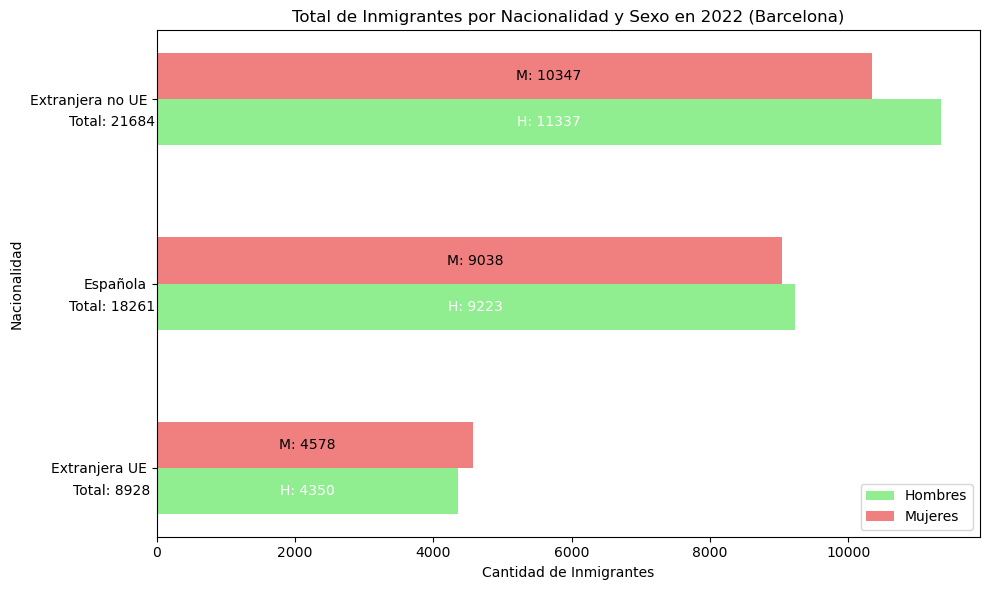

In [9]:
# Sumamos el total de inmigrantes (hombres + mujeres) por nacionalidad
total_inmigrantes = grouped_data.groupby('Nacionalidad')['Total'].sum().reset_index()

# Ordenamos las nacionalidades de mayor a menor según el total de inmigrantes
total_inmigrantes = total_inmigrantes.sort_values(by='Total', ascending=True)

# Configuramos el gráfico de barras horizontal
plt.figure(figsize=(10, 6))

# Obtenemos las posiciones en el eje Y para las barras agrupadas
y_pos = np.arange(len(total_inmigrantes))

# Ajustamos el ancho de las barras
bar_width = 0.25

# Obtenemos los datos para hombres y mujeres de cada nacionalidad
male_data = grouped_data[grouped_data['Sexo'] == 1]
female_data = grouped_data[grouped_data['Sexo'] == 2]

# Graficamos las barras para hombres y mujeres por cada nacionalidad
for i, (nacionalidad, total) in enumerate(zip(total_inmigrantes['Nacionalidad'], total_inmigrantes['Total'])):
    # Filtramos los datos por nacionalidad y lo aplicamos en hombres y mujeres
    national_data = grouped_data[grouped_data['Nacionalidad'] == nacionalidad]
    males = national_data[national_data['Sexo'] == 1]['Total'].sum()
    females = national_data[national_data['Sexo'] == 2]['Total'].sum()
    
    # Graficamos la barra para hombres (verde) y mujeres (coral) y ponemos dentro de cada uno la cantidad de inmigrantes por sexo
    plt.barh(y_pos[i], males, color='lightgreen', height=bar_width, label='Hombres')
    plt.text(males / 2, y_pos[i], f'H: {males}', ha='center', va='center', color='white', fontsize=10)
    plt.barh(y_pos[i] + bar_width, females, color='lightcoral', height=bar_width, label='Mujeres')
    plt.text(males / 2, y_pos[i] + bar_width, f'M: {females}', ha='center', va='center', color='black', fontsize=10)
    
    # Mostramos el total debajo de cada nacionalidad en el eje Y
    plt.text(-650, y_pos[i], f'Total: {males + females}', ha='center', va='center', color='black', fontsize=10)

# Configuramos las etiquetas y el título del gráfico
plt.xlabel('Cantidad de Inmigrantes')
plt.ylabel('Nacionalidad')
plt.yticks(y_pos + bar_width / 2, total_inmigrantes['Nacionalidad'])     # Mostramos las nacionalidades en el eje Y
plt.title('Total de Inmigrantes por Nacionalidad y Sexo en 2022 (Barcelona)')

# Mostramos el gráfico y su leyenda
plt.legend(['Hombres', 'Mujeres'])
plt.tight_layout()
plt.show()

## Top 5 barrios con mayor número de inmigrantes

In [10]:
def barrio_index(collection):
    try:
        # Creamos un índice en el campo Nom_Barri para mejorar el rendimiento de la consulta
        collection.create_index([("Nom_Barri", pymongo.ASCENDING)])
        print("Índice en 'Nom_Barri' creado correctamente.\n")
    except pymongo.errors.PyMongoError as e:
        print(f'Error al crear índice en MongoDB: {e}')

def top_barrios(collection):
    try:
        pipeline = [
            {"$group": {"_id": "$Nom_Barri", "count": {"$sum": 1}}},
            {"$sort": {"count": -1}},
            {"$limit": 5}  # Para hacer el Top 5
        ]
        top_barrios = list(collection.aggregate(pipeline))
        return top_barrios
    except pymongo.errors.PyMongoError as e:
        print(f'Error al obtener top 5 de nacionalidades en MongoDB: {e}')
        return []

# Crearmos el índice en Nom_Barri
barrio_index(collection)

# Obtenermos los 5 barrios con mayor población de inmigrantes
top_5_barrios = top_barrios(collection)

# Mostramos los resultados en forma de tabla
print("Top 5 Barrios con mayor número de inmigrantes en Barcelona:\n")
print(f"{'Barrio':<40} {'Total':<10}")
print("-" * 50)
for barrio in top_5_barrios:
    print(f"{barrio['_id']:<40} {barrio['count']:<10}")

Índice en 'Nom_Barri' creado correctamente.

Top 5 Barrios con mayor número de inmigrantes en Barcelona:

Barrio                                   Total     
--------------------------------------------------
la Nova Esquerra de l'Eixample           1877      
la Sagrada Família                       1718      
la Vila de Gràcia                        1647      
Sant Gervasi - Galvany                   1612      
la Dreta de l'Eixample                   1538      


In [11]:
# Definimos las coordenadas de Barcelona para crear el mapa
map_barcelona = folium.Map(location=[41.3851, 2.1734], zoom_start=13)

# Datos de los barrios con mayor número de inmigrantes obtenidos del top 5
top_5_barrios = [
    {"_id": "La Nova Esquerra de l'Eixample", "count": 7508},
    {"_id": "La Sagrada Família", "count": 6872},
    {"_id": "La Vila de Gràcia", "count": 6588},
    {"_id": "Sant Gervasi - Galvany", "count": 6448},
    {"_id": "La Dreta de l'Eixample", "count": 6152}
]

# Preparamos los datos para el mapa de calor y los marcadores
data_heatmap = []

for barrio in top_5_barrios:
    # Obtenemos el nombre del barrio y su población
    nombre_barrio = barrio['_id']
    inmigrantes = barrio['count']
    
    # Tras buscar las coordenadas de cada barrio, las incluimos en el mapa.
    if nombre_barrio == "La Nova Esquerra de l'Eixample":
        lat, lon = 41.3797, 2.1564
    elif nombre_barrio == "La Sagrada Família":
        lat, lon = 41.4045, 2.1744
    elif nombre_barrio == "La Vila de Gràcia":
        lat, lon = 41.4024, 2.1575
    elif nombre_barrio == "Sant Gervasi - Galvany":
        lat, lon = 41.3966, 2.1388
    elif nombre_barrio == "La Dreta de l'Eixample":
        lat, lon = 41.3910, 2.1647
    else:
        continue 

    # Agregamos las coordenadas y el peso (número de inmigrantes) para el mapa de calor
    if not np.isnan(lat) and not np.isnan(lon) and not np.isnan(inmigrantes):
        data_heatmap.append([lat, lon, inmigrantes])

        # Creamos marcadores emergentes para que al hacer clic en los puntos del mapa podamos ver la información de cada barrio
        folium.Marker(
            location=[lat, lon],
            popup=f"{nombre_barrio}: {inmigrantes} inmigrantes",
            icon=None  # Usamos el ícono predeterminado para los marcadores
        ).add_to(map_barcelona)

# Creamos el mapa de calor con los datos
heatmap_layer = HeatMap(data=data_heatmap, radius=15)
map_barcelona.add_child(heatmap_layer)

# Mostrar finalmente el mapa interactivo con el mapa de calor y marcadores
map_barcelona

## Inmigrantes según nacionalidad y barrio

In [12]:
# Filtramos los datos por las nacionalidades de interés (1: Española, 2: UE, 3: Fuera de la UE)
pipeline = [
    {"$match": {"NACIONALITAT_G": {"$in": [1, 2, 3]}}},
    {"$group": {"_id": {"Nom_Barri": "$Nom_Barri", "NACIONALITAT_G": "$NACIONALITAT_G"}, "Total": {"$sum": 1}}}
]

# Ejecutamos la consulta en MongoDB
results = list(collection.aggregate(pipeline))

# Creamos un DataFrame a partir de los resultados
df = pd.DataFrame(results)

# Agregamos una columna llamada 'Nacionalidad' basada en el mapeo de códigos del ejercicio anterior
df['Nacionalidad'] = df['_id'].apply(lambda x: nacionalidad_map.get(x['NACIONALITAT_G']))
# Extraemos los datos de 'Nom_Barri'
df['Nom_Barri'] = df['_id'].apply(lambda x: x.get('Nom_Barri'))

# Filtramos por las nacionalidades específicas y agrupamos por barrio para obtener los totales
spanish_immigrants = df[df['Nacionalidad'] == 'Española'].groupby('Nom_Barri')['Total'].sum().sort_values(ascending=False)
eu_immigrants = df[df['Nacionalidad'] == 'Extranjera UE'].groupby('Nom_Barri')['Total'].sum().sort_values(ascending=False)
non_eu_immigrants = df[df['Nacionalidad'] == 'Extranjera no UE'].groupby('Nom_Barri')['Total'].sum().sort_values(ascending=False)

# Obtenemos el barrio con más inmigrantes españoles, de la UE y fuera de la UE y su cantidad
barrio_most_spanish = spanish_immigrants.idxmax()
num_spanish_immigrants = spanish_immigrants.max()

barrio_most_eu = eu_immigrants.idxmax()
num_eu_immigrants = eu_immigrants.max()

barrio_most_non_eu = non_eu_immigrants.idxmax()
num_non_eu_immigrants = non_eu_immigrants.max()

# Mostramos los resultados
print(f"Barrio con más inmigrantes españoles -----> {barrio_most_spanish} ({num_spanish_immigrants} inmigrantes)\n")
print(f"Barrio con más inmigrantes de la UE -----> {barrio_most_eu} ({num_eu_immigrants} inmigrantes)\n")
print(f"Barrio con más inmigrantes fuera de la UE -----> {barrio_most_non_eu} ({num_non_eu_immigrants} inmigrantes)\n")

Barrio con más inmigrantes españoles -----> la Nova Esquerra de l'Eixample (699 inmigrantes)

Barrio con más inmigrantes de la UE -----> la Vila de Gràcia (417 inmigrantes)

Barrio con más inmigrantes fuera de la UE -----> la Nova Esquerra de l'Eixample (817 inmigrantes)



In [13]:
# Definimos una función para crear un mapa centrado en los barrios obtenidos en los resultados
def crear_mapa_barrio(lat, lon, barrio, tipo_inmigrantes):
    # Creamos un mapa centrado en las coordenadas que añadiremos más tarde
    mapa_barrio = folium.Map(location=[lat, lon], zoom_start=15)
    
    # Agregamos un marcador al mapa para mostrar el barrio y el tipo de inmigrantes
    folium.Marker(
        location=[lat, lon],
        popup=f"{barrio} ({tipo_inmigrantes} inmigrantes)",
        icon=folium.Icon(color='red')
    ).add_to(mapa_barrio)
    
    # Mostramos el mapa interactivo
    return mapa_barrio

# Datos de los barrios con mayor número de inmigrantes
barrios_inmigrantes = {
    "la Nova Esquerra de l'Eixample": {"lat": 41.3797, "lon": 2.1564, "tipo": "españoles", "inmigrantes": 699},
    "la Vila de Gràcia": {"lat": 41.4024, "lon": 2.1575, "tipo": "UE", "inmigrantes": 417},
    "la Nova Esquerra de l'Eixample": {"lat": 41.3797, "lon": 2.1564, "tipo": "fuera de la UE", "inmigrantes": 817}
}

# Creamos y mostramos cada mapa para los barrios especificados
for barrio, info in barrios_inmigrantes.items():
    lat = info['lat']
    lon = info['lon']
    tipo_inmigrantes = info['tipo']
    inmigrantes = info['inmigrantes']
    
    mapa = crear_mapa_barrio(lat, lon, barrio, tipo_inmigrantes)
    
    # Mostramos el mapa con el título correspondiente
    print(f"\nMapa de '{barrio}' con inmigrantes '{tipo_inmigrantes}'\n")
    display(mapa)



Mapa de 'la Nova Esquerra de l'Eixample' con inmigrantes 'fuera de la UE'




Mapa de 'la Vila de Gràcia' con inmigrantes 'UE'



## Inmigrantes por edad quinquenal

In [14]:
# Pipeline de agregación para contar inmigrantes por categoría de edad quinquenal
pipeline = [
    {
        "$group": {
            "_id": {
                "$switch": {
                    "branches": [
                        {"case": {"$lte": ["$EDAT_Q", 3]}, "then": "Niños"},  # De 0 a 14 años
                        {"case": {"$lte": ["$EDAT_Q", 4]}, "then": "Adolescentes"}, # De 15 al 19 años
                        {"case": {"$lte": ["$EDAT_Q", 9]}, "then": "Jóvenes"}, # de 20 a 39 años
                        {"case": {"$lte": ["$EDAT_Q", 19]}, "then": "Adultos"}, # De 40 a 59 años
                        {"case": {"$gt": ["$EDAT_Q", 19]}, "then": "Personas mayores"}  # De 60 años en adelante
                    ],
                    "default": "Otro"
                }
            },
            "Total": {"$sum": 1}
        }
    },
    {
        "$project": {
            "_id": 0,
            "Edad": "$_id",
            "Total": 1
        }
    },
]

# Realizamos una consulta para obtener los datos agrupados por edad quinquenal
cursor = collection.aggregate(pipeline)

# Creamos un DataFrame a partir de los documentos obtenidos de la consulta
df = pd.DataFrame(list(cursor))

# Definimos el orden de las categorías para una mejor visibilidad
orden_categorias = ["Niños", "Adolescentes", "Jóvenes", "Adultos", "Personas mayores"]

# Creamos una nueva columna en el DataFrame para asignar el orden específico
df['Orden'] = pd.Categorical(df['Edad'], categories=orden_categorias, ordered=True)

# Ordenamos el DataFrame según el nuevo orden específico y eliminamos la columna de orden temporal
df_sorted = df.sort_values(by='Orden')
df_sorted.drop(columns=['Orden'], inplace=True)

# Mostramos los datos agrupados por edad quinquenal y total de inmigrantes en el orden deseado
print("Edad".ljust(20), "Total")
print("-" * 30)

for index, row in df_sorted.iterrows():
    print(row['Edad'].ljust(20), row['Total'])

Edad                 Total
------------------------------
Niños                9862
Adolescentes         4763
Jóvenes              22443
Adultos              11898
Personas mayores     6


Edad                 Hombre Mujer
-----------------------------------
Niños                4945   4917
Adolescentes         2456   2307
Jóvenes              11044  11399
Adultos              6520   5378
Personas mayores     5      1


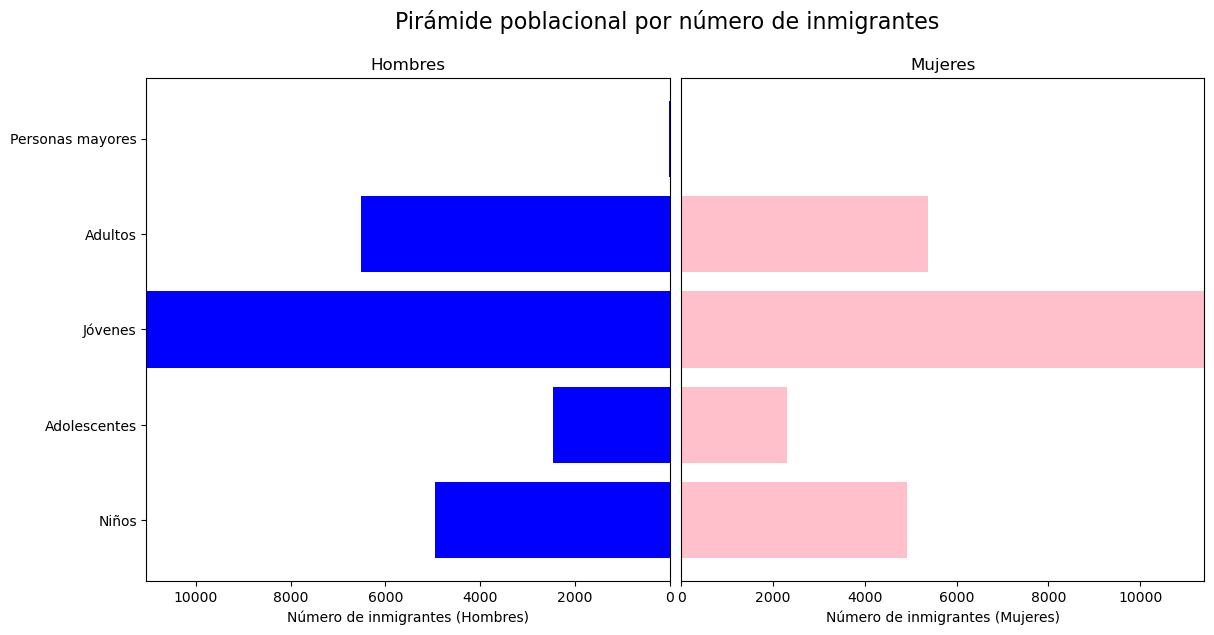

In [158]:
# Pipeline de agregación para contar inmigrantes por categoría de edad quinquenal y género
pipeline = [
    {
        "$group": {
            "_id": {
                "Edad": {
                    "$switch": {
                        "branches": [
                            {"case": {"$lte": ["$EDAT_Q", 3]}, "then": "Niños"},  # De 0 a 14 años
                            {"case": {"$lte": ["$EDAT_Q", 4]}, "then": "Adolescentes"}, # De 15 al 19 años
                            {"case": {"$lte": ["$EDAT_Q", 9]}, "then": "Jóvenes"}, # de 20 a 39 años
                            {"case": {"$lte": ["$EDAT_Q", 19]}, "then": "Adultos"}, # De 40 a 59 años
                            {"case": {"$gt": ["$EDAT_Q", 19]}, "then": "Personas mayores"}  # De 60 años en adelante
                        ],
                        "default": "Otro"
                    }
                },
                "Sexo": "$SEXE"
            },
            "Total": {"$sum": 1}
        }
    },
    {
        "$project": {
            "_id": 0,
            "Edad": "$_id.Edad",
            "Sexo": "$_id.Sexo",
            "Total": 1
        }
    }
]

# Realizamos una consulta para obtener los datos de la colección
cursor = collection.aggregate(pipeline)

# Creamos un DataFrame a partir de los documentos obtenidos de la consulta
df = pd.DataFrame(list(cursor))

# Creamos un pivot table para contar hombres y mujeres por categoría de edad
pivot_table = pd.pivot_table(df, values='Total', index='Edad', columns='Sexo', aggfunc='sum', fill_value=0)

# Cambiamos los encabezados de las columnas a 'Hombre' y 'Mujer'
pivot_table.columns = ['Hombre', 'Mujer']

# Definimos el orden personalizado de las categorías de edad
orden_categorias = ['Niños', 'Adolescentes', 'Jóvenes', 'Adultos', 'Personas mayores']

# Ordenamos el pivot table según el orden personalizado de las categorías de edad
pivot_table = pivot_table.reindex(orden_categorias)

# Mostramos el pivot table con los encabezados actualizados
print("Edad".ljust(20), "Hombre", "Mujer")
print("-" * 35)

for index, row in pivot_table.iterrows():
    print(index.ljust(20), str(row['Hombre']).ljust(6), str(row['Mujer']))

# Graficamos la pirámide poblacional combinada
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Gráfico de barras invertidas para hombres (parte izquierda)
ax1.barh(pivot_table.index, pivot_table['Hombre'], color='blue')
ax1.set_xlim(pivot_table['Hombre'].max(), 0)  # Invertimos el eje x para que no salgan cantidades negativas
ax1.set_xlabel('Número de inmigrantes (Hombres)')
ax1.set_title('Hombres')

# Gráfico de barras invertidas para mujeres (parte derecha)
ax2.barh(pivot_table.index, pivot_table['Mujer'], color='pink')
ax2.set_xlim(0, pivot_table['Mujer'].max())  # Dejamos igual el eje x
ax2.set_xlabel('Número de inmigrantes (Mujeres)')
ax2.set_yticks([])  # Eliminamos las etiquetas del eje Y para mujeres para poder mostrar los dos gráficos juntos
ax2.set_title('Mujeres')

# Ajustar el espacio entre los subplots
fig.suptitle('Pirámide poblacional por número de inmigrantes', fontsize=16, x= 0.55, y=1.03) # Insertamos un título general y lo ajustamos 
plt.tight_layout(pad = 0.2)

# Mostramos la pirámide poblacional combinada
plt.show()

## Inmigrantes según edad y barrio

In [16]:
# Pipeline de agregación para contar inmigrantes por categoría de edad quinquenal y barrio
pipeline = [
    {
        "$group": {
            "_id": {
                "Edad": {
                    "$switch": {
                        "branches": [
                            {"case": {"$lte": ["$EDAT_Q", 3]}, "then": "Niños"},  # De 0 a 14 años
                            {"case": {"$lte": ["$EDAT_Q", 4]}, "then": "Adolescentes"}, # De 15 al 19 años
                            {"case": {"$lte": ["$EDAT_Q", 9]}, "then": "Jóvenes"}, # de 20 a 39 años
                            {"case": {"$lte": ["$EDAT_Q", 19]}, "then": "Adultos"}, # De 40 a 59 años
                            {"case": {"$gt": ["$EDAT_Q", 19]}, "then": "Personas mayores"}  # De 60 años en adelante
                        ],
                        "default": "Otro"
                    }
                },
                "Nom_Barri": "$Nom_Barri"
            },
            "Total": {"$sum": 1}
        }
    },
    {
        "$sort": {
            "Total": -1  # Orden descendente por el total de inmigrantes
        }
    },
    {
        "$group": {
            "_id": "$_id.Edad",
            "Barrio_mas_poblado": {"$first": "$_id.Nom_Barri"},
            "Total_inmigrantes": {"$first": "$Total"}
        }
    },
    {
        "$project": {
            "_id": 0,
            "Edad": {
                "$switch": {
                    "branches": [
                        {"case": {"$eq": ["$_id", "Niños"]}, "then": 0},
                        {"case": {"$eq": ["$_id", "Adolescentes"]}, "then": 1},
                        {"case": {"$eq": ["$_id", "Jóvenes"]}, "then": 2},
                        {"case": {"$eq": ["$_id", "Adultos"]}, "then": 3},
                        {"case": {"$eq": ["$_id", "Personas mayores"]}, "then": 4}
                    ],
                    "default": 5
                }
            },
            "Barrio_mas_poblado": 1,
            "Total_inmigrantes": 1
        }
    },
]

# Realizamos una consulta para obtener los barrios más poblados por edad
cursor = collection.aggregate(pipeline)

# Creamos un DataFrame a partir de los documentos obtenidos de la consulta
df_result = pd.DataFrame(list(cursor))

# Definimos el orden específico de las categorías de edad
orden_edad = ["Niños", "Adolescentes", "Jóvenes", "Adultos", "Personas mayores"]

# Mapeamos los valores numéricos a las categorías de edad
df_result['Edad'] = df_result['Edad'].map({0: "Niños", 1: "Adolescentes", 2: "Jóvenes", 3: "Adultos", 4: "Personas mayores"})

# Ordenamos el DataFrame según el nuevo orden específico
df_result['Edad'] = pd.Categorical(df_result['Edad'], categories=orden_edad, ordered=True)
df_result = df_result.sort_values(by='Edad')

# Mostramos los resultados formateados
print("Edad".ljust(20), "Barrio más poblado".ljust(40), "Total de inmigrantes")
print("-" * 80)

for index, row in df_result.iterrows():
    edad_str = str(row['Edad'])  # Convertir la categoría de edad a cadena
    print(edad_str.ljust(20), row['Barrio_mas_poblado'].ljust(40), row['Total_inmigrantes'])

Edad                 Barrio más poblado                       Total de inmigrantes
--------------------------------------------------------------------------------
Niños                Sant Gervasi - Galvany                   399
Adolescentes         la Nova Esquerra de l'Eixample           200
Jóvenes              la Nova Esquerra de l'Eixample           891
Adultos              la Nova Esquerra de l'Eixample           461
Personas mayores     Sant Gervasi - la Bonanova               2


## Inmigrantes según nacionalidad, edad y barrio

In [23]:
# Pipeline de agregación para contar inmigrantes por nacionalidad, categoría de edad quinquenal y barrio
pipeline = [
    {
        "$match": {
            # Filtramos por el mapeo anterior de nacionalidades (1: Española, 2: UE, 3: Fuera de la UE) para evitar los NaN
            "NACIONALITAT_G": {"$in": [1, 2, 3]}  
        }
    },
    {
        "$group": {
            "_id": {
                "Nacionalidad": {
                    "$switch": {
                        "branches": [
                            {"case": {"$eq": ["$NACIONALITAT_G", 1]}, "then": "Español"},
                            {"case": {"$eq": ["$NACIONALITAT_G", 2]}, "then": "UE"},
                            {"case": {"$eq": ["$NACIONALITAT_G", 3]}, "then": "Fuera de la UE"}
                        ],
                        "default": "Otro"
                    }
                },
                "Edad": {
                    "$switch": {
                        "branches": [
                            {"case": {"$lte": ["$EDAT_Q", 3]}, "then": "Niños"},  # De 0 a 14 años
                            {"case": {"$lte": ["$EDAT_Q", 4]}, "then": "Adolescentes"}, # De 15 al 19 años
                            {"case": {"$lte": ["$EDAT_Q", 9]}, "then": "Jóvenes"}, # de 20 a 39 años
                            {"case": {"$lte": ["$EDAT_Q", 19]}, "then": "Adultos"}, # De 40 a 59 años
                            {"case": {"$gt": ["$EDAT_Q", 19]}, "then": "Personas mayores"}  # De 60 años en adelante
                        ],
                        "default": "Otro"
                    }
                },
                "Nom_Barri": "$Nom_Barri"
            },
            "Total": {"$sum": 1}  # Contar el número de inmigrantes
        }
    },
    {
        "$sort": {
            "Total": -1
        }
    },
    {
        "$group": {
            "_id": {
                "Nacionalidad": "$_id.Nacionalidad",
                "Edad": "$_id.Edad"
            },
            "Barrio_mas_poblado": {"$first": "$_id.Nom_Barri"},
            "Total_inmigrantes": {"$first": "$Total"}
        }
    }
]

# Ejecutamos el pipeline en MongoDB
cursor = collection.aggregate(pipeline)

# Convertimos los resultados en un DataFrame de pandas
results = list(cursor)
df_result = pd.DataFrame(results)

# Orden de nacionalidades y grupos de edad
orden_nacionalidad = ["Español", "UE", "Fuera de la UE"]
orden_edad = ["Niños", "Adolescentes", "Jóvenes", "Adultos", "Personas mayores"]

# Mostramos los resultados ordenados por nacionalidad y luego por edad
print("Nacionalidad".ljust(20), "Edad".ljust(20), "Barrio más poblado".ljust(40), "Total de inmigrantes")
print("-" * 100)

# Iteramos sobre el orden de nacionalidades y luego sobre el orden de edad
for nacionalidad in orden_nacionalidad:
    for edad in orden_edad:
        # Filtramos los resultados por nacionalidad y edad
        filtro = (df_result["_id"].apply(lambda x: x['Nacionalidad']) == nacionalidad) & (df_result["_id"].apply(lambda x: x['Edad']) == edad)
        df_filtrado = df_result[filtro]
        
        # Verificamos si hay datos para esta combinación de nacionalidad y edad
        if not df_filtrado.empty:
            # Obtenemos el primer (y único) resultado para esta combinación
            row = df_filtrado.iloc[0]
            
            # Imprimimos los resultados formateados
            print(
                str(nacionalidad).ljust(20),
                str(edad).ljust(20),
                row['Barrio_mas_poblado'].ljust(40),
                row['Total_inmigrantes']
            )
        else:
            # Si no hay datos para esta combinación, imprimimos una línea en blanco
            print("".ljust(20), "".ljust(20), "".ljust(40), "")

Nacionalidad         Edad                 Barrio más poblado                       Total de inmigrantes
----------------------------------------------------------------------------------------------------
Español              Niños                Sant Gervasi - Galvany                   139
Español              Adolescentes         la Nova Esquerra de l'Eixample           68
Español              Jóvenes              la Nova Esquerra de l'Eixample           322
Español              Adultos              la Nova Esquerra de l'Eixample           202
Español              Personas mayores     Sant Gervasi - la Bonanova               2
UE                   Niños                Sant Gervasi - Galvany                   101
UE                   Adolescentes         la Vila de Gràcia                        65
UE                   Jóvenes              la Vila de Gràcia                        248
UE                   Adultos              Sant Gervasi - Galvany                   65
                 

In [26]:
# Creamos un mapa centrado en Barcelona
m = folium.Map(location=[41.3851, 2.1734], zoom_start=12)

# Definimos los colores para cada nacionalidad
colors = {
    'Español': 'blue',
    'UE': 'green',
    'Fuera de la UE': 'red'
}

# Agregamos la leyenda de colores y nacionalidades
legend_html = '''
<div style="position: fixed; 
     top: 10px; right: 10px; width: 200px; height: 125px; 
     border:2px solid grey; z-index:9999; font-size:14px; background-color:white; padding: 10px; text-align: left;
     ">
     <strong style="font-size: 16px;">Color Legend</strong><br>
     <div style="display: flex; align-items: center;">
         <i class="fa fa-map-marker fa-2x" style="color:blue; margin-right: 10px;"></i>
         <span>Español</span>
     </div>
     <div style="display: flex; align-items: center;">
         <i class="fa fa-map-marker fa-2x" style="color:green; margin-right: 10px;"></i>
         <span>UE</span>
     </div>
     <div style="display: flex; align-items: center;">
         <i class="fa fa-map-marker fa-2x" style="color:red; margin-right: 10px;"></i>
         <span>Fuera de la UE</span>
     </div>
</div>
'''

m.get_root().html.add_child(folium.Element(legend_html))

# Agregamos marcadores para cada nacionalidad y edad en los barrios correspondientes
data = {
    ('Español', 'Niños'): (41.3994, 2.1438, 139),  # Coordenadas para niños españoles
    ('Español', 'Adolescentes'): (41.3797, 2.1565, 68),  # Coordenadas para adolescentes españoles 
    ('Español', 'Jóvenes'): (41.3853, 2.1571, 322),  # Coordenadas para jóvenes españoles
    ('Español', 'Adultos'): (41.3845, 2.1555, 202),  # Coordenadas para adultos españoles
    ('Español', 'Personas mayores'): (41.4029, 2.1474, 2),  # Coordenadas para personas mayores españoles
    ('UE', 'Niños'): (41.3994, 2.1761, 101),  # Coordenadas para niños de la UE
    ('UE', 'Adolescentes'): (41.3987, 2.1676, 65),  # Coordenadas para adolescentes de la UE
    ('UE', 'Jóvenes'): (41.4045, 2.1708, 248),  # Coordenadas para jóvenes de la UE
    ('UE', 'Adultos'): (41.3902, 2.1535, 65),  # Coordenadas para adultos de la UE
    ('Fuera de la UE', 'Niños'): (41.4042, 2.1667, 188),  # Coordenadas para niños fuera de la UE
    ('Fuera de la UE', 'Adolescentes'): (41.3856, 2.1569, 73),  # Coordenadas para adolescentes fuera de la UE
    ('Fuera de la UE', 'Jóvenes'): (41.3831, 2.1555, 340),  # Coordenadas para jóvenes fuera de la UE
    ('Fuera de la UE', 'Adultos'): (41.3888, 2.1703, 218)  # Coordenadas para adultos fuera de la UE
}

# Rango para el tamaño del ícono (ajustar según tus necesidades)
min_size = 10
max_size = 50

for (nacionalidad, edad), (lat, lon, total_inmigrantes) in data.items():
    # Calculamos el tamaño del icono en función de la cantidad total de inmigrantes
    size_factor = (total_inmigrantes - min(data.values(), key=lambda x: x[2])[2]) / (max(data.values(), key=lambda x: x[2])[2] - min(data.values(), key=lambda x: x[2])[2])
    icon_size = min_size + (max_size - min_size) * size_factor
    
    folium.Marker(
        location=(lat, lon),
        popup=f"{edad}, {total_inmigrantes} inmigrantes",
        icon=folium.DivIcon(html=f'<div style="font-size: {icon_size}px; color: {colors[nacionalidad]};"><i class="fa fa-child fa-lg"></i></div>')
    ).add_to(m)

# Mostramos el mapa
m